# Melhoria do Random Forest para Classificação Binária:Machine Learning I

Trabalho de:
- Inês Castro up202304060
- Simão Gomes up202304752
- Soraia Costa up202305078


## Índice

- [Introducao](#introducao)
- 

## Introdução



In [5]:
import os

origem = r'C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance'
destino = r'C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance_small'

os.makedirs(destino, exist_ok=True)

for file in os.listdir(origem):

    ori = os.path.join(origem, file)
    df = pd.read_csv(ori)

    if df.shape[0] < 700:
        dest = os.path.join(destino, file)
        os.rename(ori, dest)


In [8]:
#Removing multiclass files
os.remove(r'C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance\dataset_312_scene.csv')
os.remove(r'C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance\dataset_316_yeast_ml8.csv')

In [23]:
import os
import pandas as pd
import numpy as np

pastas = [r"C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance",r"C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance_small"]

minority_rates = []
linhastotais = 0
taxatotal = 0 
colunastotais = 0

for pasta in pastas:
    for arquivo in os.listdir(pasta):

        if arquivo.endswith(".csv"):

            caminho_arquivo = os.path.join(pasta, arquivo)
            df = pd.read_csv(caminho_arquivo)
            linhastotais += len(df)
            colunastotais += df.shape[1]

            y = df.iloc[:, -1].values

            classes, counts = np.unique(y, return_counts=True)

            min_count = np.min(counts)
            total = len(y)
            min_rate = min_count / total
            taxatotal += min_rate

            minority_rates.append({
                "dataset": arquivo,
                "minority_class": classes[np.argmin(counts)],
                "minority_rate": min_rate
            })

resultados_df = pd.DataFrame(minority_rates)
print(resultados_df)
print("\nTaxa média da classe minoritária", (taxatotal/48).round(2))
print("Número médio de linhas", int(linhastotais/48))
print("Número médio de colunas", int(colunastotais/48))

                                    dataset minority_class  minority_rate
0              dataset_1000_hypothyroid.csv              0       0.077147
1        dataset_1002_ipums_la_98-small.csv              0       0.105678
2         dataset_1014_analcatdata_dmft.csv              1       0.194479
3                    dataset_1016_vowel.csv              1       0.090909
4        dataset_1018_ipums_la_99-small.csv              0       0.064224
5           dataset_1020_mfeat-karhunen.csv              1       0.100000
6              dataset_1021_page-blocks.csv              0       0.102320
7              dataset_1022_mfeat-pixel.csv              1       0.100000
8            dataset_1039_hiva_agnostic.csv              1       0.035233
9                      dataset_1049_pc4.csv           True       0.122085
10                     dataset_1050_pc3.csv           True       0.102367
11                     dataset_1056_mc1.csv           True       0.007184
12                dataset_311_oil_spil

**Análise do desempenho do Random Forest incial, sem qualquer alteraçoes**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mla.ensemble.random_forest import RandomForestClassifier  # Usando a tua implementação

# Pasta dos datasets tratados
pastas = [r"C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance",r"C:\Users\Utilizador\Desktop\RandomForest_v2\clean_class_imbalance_small"]

resultados = []
count = 1

# Funções de métricas sem sklearn
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision(y_true, y_pred):
    classes = np.unique(y_true)
    precisions = []
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        precisions.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    return np.mean(precisions)

def recall(y_true, y_pred):
    classes = np.unique(y_true)
    recalls = []
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        recalls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    return np.mean(recalls)

def recall_minority(y_true, y_pred):
    classes, counts = np.unique(y_true, return_counts=True)
    min_class = classes[np.argmin(counts)]
    tp = np.sum((y_pred == min_class) & (y_true == min_class))
    fn = np.sum((y_pred != min_class) & (y_true == min_class))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def balanced_accuracy(y_true, y_pred):
    classes = np.unique(y_true)
    recalls = []
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        recalls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    return np.mean(recalls)

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

def precision_recall_auc(y_true, y_score):
    if len(np.unique(y_true)) != 2:
        return np.nan
    y_true = y_true.astype(int)
    prob = y_score[:, 1]
    desc_order = np.argsort(-prob)
    y_true_sorted = y_true[desc_order]
    precision_vals = np.cumsum(y_true_sorted) / (np.arange(1, len(y_true_sorted) + 1))
    recall_vals = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    return np.trapz(precision_vals, recall_vals)


# Função para dividir treino e teste
def split_train_test(X, y, test_size=0.3, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    test_size = int(test_size * X.shape[0])
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

max_depths = [5,10,25,50]
n_estimators = [10, 50, 100, 200]

Max_Depth tuninh

In [ ]:
pasta = pastas[1]  # Usando a pasta com datasets pequenos

for arquivo in os.listdir(pasta):
    if arquivo.endswith(".csv"):
        caminho_arquivo = os.path.join(pasta, arquivo)
        print(f"\nTreino no dataset: {arquivo}")
        print(count, "de 48")
        count += 1

        # Carrega dados
        df = pd.read_csv(caminho_arquivo)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        num_atributos = X.shape[1]
        # Divide treino/teste
        X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)

        for depth in max_depths:
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=5,
                max_depth=depth,
                max_features= math.floor(math.sqrt(num_atributos))
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)

            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)

            resultados.append({
                "dataset": arquivo,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc,
                "max_depth": depth
            })


Treino no dataset: dataset_1004_synthetic_control.csv
1 de 48

Treino no dataset: dataset_1013_analcatdata_challenger.csv
2 de 48

Treino no dataset: dataset_1023_soybean.csv
3 de 48

Treino no dataset: dataset_1045_kc1-top5.csv
4 de 48

Treino no dataset: dataset_1059_ar1.csv
5 de 48

Treino no dataset: dataset_1061_ar4.csv
6 de 48

Treino no dataset: dataset_1064_ar6.csv
7 de 48

Treino no dataset: dataset_1065_kc3.csv
8 de 48

Treino no dataset: dataset_450_analcatdata_lawsuit.csv
9 de 48

Treino no dataset: dataset_463_backache.csv
10 de 48

Treino no dataset: dataset_757_meta.csv
11 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_764_analcatdata_apnea3.csv
12 de 48

Treino no dataset: dataset_765_analcatdata_apnea2.csv
13 de 48

Treino no dataset: dataset_767_analcatdata_apnea1.csv
14 de 48

Treino no dataset: dataset_865_analcatdata_neavote.csv
15 de 48

Treino no dataset: dataset_867_visualizing_livestock.csv
16 de 48

Treino no dataset: dataset_875_analcatdata_chlamydia.csv
17 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_940_water-treatment.csv
18 de 48

Treino no dataset: dataset_947_arsenic-male-bladder.csv
19 de 48

Treino no dataset: dataset_949_arsenic-female-bladder.csv
20 de 48

Treino no dataset: dataset_950_arsenic-female-lung.csv
21 de 48

Treino no dataset: dataset_951_arsenic-male-lung.csv
22 de 48

Treino no dataset: dataset_954_spectrometer.csv
23 de 48

Treino no dataset: dataset_968_analcatdata_birthday.csv
24 de 48

Treino no dataset: dataset_984_analcatdata_draft.csv
25 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_987_collins.csv
26 de 48


In [25]:
pasta = pastas[0] 

for arquivo in os.listdir(pasta):
    if arquivo.endswith(".csv"):
        caminho_arquivo = os.path.join(pasta, arquivo)
        print(f"\nTreino no dataset: {arquivo}")
        print(count, "de 48")
        count += 1

        # Carrega dados
        df = pd.read_csv(caminho_arquivo)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        num_atributos = X.shape[1]
        # Divide treino/teste
        X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)


        for depth in max_depths:
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=50,
                max_depth= depth,
                max_features= math.floor(math.sqrt(num_atributos)),
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)

            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)
            

            resultados.append({
                "dataset": arquivo,
                "max_depth": depth,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc
            })

# Mostrar resultados
resultados_df = pd.DataFrame(resultados)
resultados_df.to_csv("analise_inicial_rf.csv", index=False)
print("\nResultados:")
print(resultados_df)



Treino no dataset: dataset_1000_hypothyroid.csv
27 de 48

Treino no dataset: dataset_1002_ipums_la_98-small.csv
28 de 48

Treino no dataset: dataset_1014_analcatdata_dmft.csv
29 de 48

Treino no dataset: dataset_1016_vowel.csv
30 de 48

Treino no dataset: dataset_1018_ipums_la_99-small.csv
31 de 48

Treino no dataset: dataset_1020_mfeat-karhunen.csv
32 de 48

Treino no dataset: dataset_1021_page-blocks.csv
33 de 48

Treino no dataset: dataset_1022_mfeat-pixel.csv
34 de 48

Treino no dataset: dataset_1039_hiva_agnostic.csv
35 de 48

Treino no dataset: dataset_1049_pc4.csv
36 de 48

Treino no dataset: dataset_1050_pc3.csv
37 de 48

Treino no dataset: dataset_1056_mc1.csv
38 de 48

Treino no dataset: dataset_311_oil_spill.csv
39 de 48

Treino no dataset: dataset_38_sick.csv
40 de 48

Treino no dataset: dataset_958_segment.csv
41 de 48

Treino no dataset: dataset_962_mfeat-morphological.csv
42 de 48

Treino no dataset: dataset_966_analcatdata_halloffame.csv
43 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_971_mfeat-fourier.csv
44 de 48

Treino no dataset: dataset_976_JapaneseVowels.csv
45 de 48

Treino no dataset: dataset_978_mfeat-factors.csv
46 de 48

Treino no dataset: dataset_980_optdigits.csv
47 de 48

Treino no dataset: dataset_995_mfeat-zernike.csv
48 de 48

Resultados:
                                     dataset  f1_score  recall_minority  \
0         dataset_1004_synthetic_control.csv  1.000000         1.000000   
1         dataset_1004_synthetic_control.csv  0.990227         0.967742   
2         dataset_1004_synthetic_control.csv  1.000000         1.000000   
3         dataset_1004_synthetic_control.csv  0.990227         0.967742   
4    dataset_1013_analcatdata_challenger.csv  1.000000         1.000000   
..                                       ...       ...              ...   
187                dataset_980_optdigits.csv  0.955346         0.843931   
188            dataset_995_mfeat-zernike.csv  0.973214         0.903846   
189            datas

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

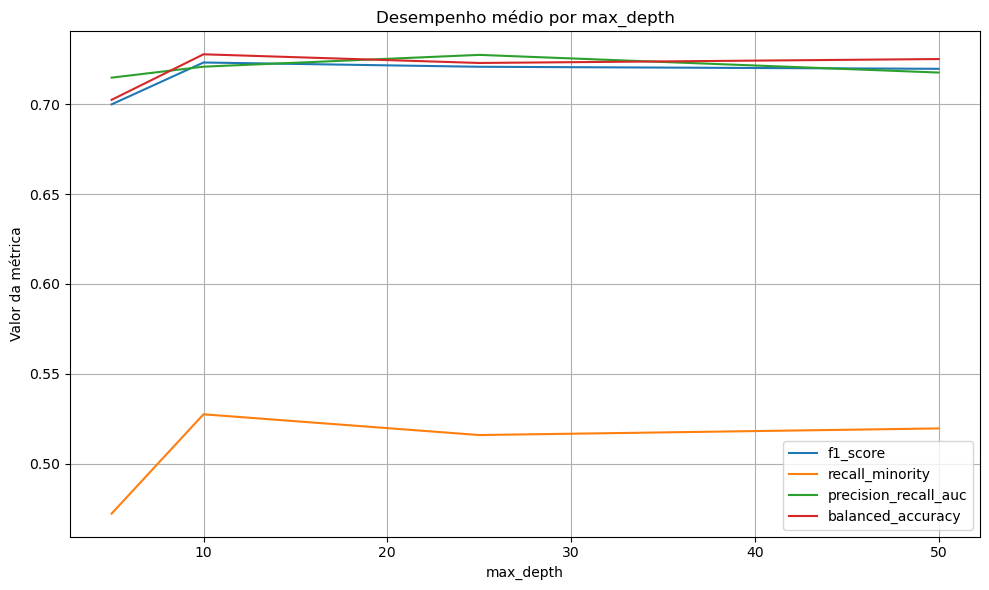

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

resultados_df=pd.read_csv(r'C:\Users\Utilizador\Desktop\RandomForest_v2\analise_inicial_depth_rf.csv')
mean_results = resultados_df.groupby("max_depth").mean(numeric_only=True).reset_index()

plt.figure(figsize=(10, 6))
for metric in ["f1_score", "recall_minority", "precision_recall_auc", "balanced_accuracy"]:
    sns.lineplot(data=mean_results, x="max_depth", y=metric, label=metric)

plt.title("Desempenho médio por max_depth")
plt.xlabel("max_depth")
plt.ylabel("Valor da métrica")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='max_depth', ylabel='recall_minority'>

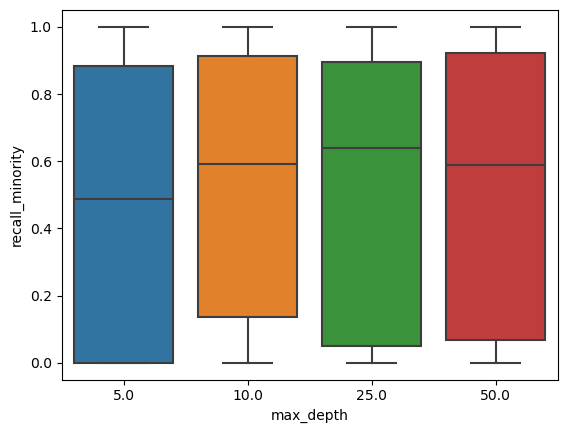

In [46]:
sns.boxplot(data=resultados_df, x="max_depth", y="recall_minority")

No_estimators tuning

In [49]:
resultados_est=[]
count = 1

In [50]:
pasta = pastas[1] 

for arquivo in os.listdir(pasta):
    if arquivo.endswith(".csv"):
        caminho_arquivo = os.path.join(pasta, arquivo)
        print(f"\nTreino no dataset: {arquivo}")
        print(count, "de 48")
        count += 1

        # Carrega dados
        df = pd.read_csv(caminho_arquivo)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        num_atributos = X.shape[1]
        # Divide treino/teste
        X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)


        for n in n_estimators:
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=n,
                max_depth= 10,
                max_features= math.floor(math.sqrt(num_atributos)),
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)

            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)
            

            resultados_est.append({
                "dataset": arquivo,
                "n_estimators": n,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc
            })


Treino no dataset: dataset_1004_synthetic_control.csv
1 de 48

Treino no dataset: dataset_1013_analcatdata_challenger.csv
2 de 48

Treino no dataset: dataset_1023_soybean.csv
3 de 48

Treino no dataset: dataset_1045_kc1-top5.csv
4 de 48

Treino no dataset: dataset_1059_ar1.csv
5 de 48

Treino no dataset: dataset_1061_ar4.csv
6 de 48

Treino no dataset: dataset_1064_ar6.csv
7 de 48

Treino no dataset: dataset_1065_kc3.csv
8 de 48

Treino no dataset: dataset_450_analcatdata_lawsuit.csv
9 de 48

Treino no dataset: dataset_463_backache.csv
10 de 48

Treino no dataset: dataset_757_meta.csv
11 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_764_analcatdata_apnea3.csv
12 de 48

Treino no dataset: dataset_765_analcatdata_apnea2.csv
13 de 48

Treino no dataset: dataset_767_analcatdata_apnea1.csv
14 de 48

Treino no dataset: dataset_865_analcatdata_neavote.csv
15 de 48

Treino no dataset: dataset_867_visualizing_livestock.csv
16 de 48

Treino no dataset: dataset_875_analcatdata_chlamydia.csv
17 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_940_water-treatment.csv
18 de 48

Treino no dataset: dataset_947_arsenic-male-bladder.csv
19 de 48

Treino no dataset: dataset_949_arsenic-female-bladder.csv
20 de 48

Treino no dataset: dataset_950_arsenic-female-lung.csv
21 de 48

Treino no dataset: dataset_951_arsenic-male-lung.csv
22 de 48

Treino no dataset: dataset_954_spectrometer.csv
23 de 48

Treino no dataset: dataset_968_analcatdata_birthday.csv
24 de 48

Treino no dataset: dataset_984_analcatdata_draft.csv
25 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_987_collins.csv
26 de 48


In [51]:
pasta = pastas[0] 

for arquivo in os.listdir(pasta):
    if arquivo.endswith(".csv"):
        caminho_arquivo = os.path.join(pasta, arquivo)
        print(f"\nTreino no dataset: {arquivo}")
        print(count, "de 48")
        count += 1

        # Carrega dados
        df = pd.read_csv(caminho_arquivo)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        num_atributos = X.shape[1]
        # Divide treino/teste
        X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)


        for n in n_estimators:
            
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=n,
                max_depth= 10,
                max_features= math.floor(math.sqrt(num_atributos)),
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)

            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)
            

            resultados_est.append({
                "dataset": arquivo,
                "n_estimators": n,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc
            })

# Mostrar resultados
resultados_est_df = pd.DataFrame(resultados_est)
resultados_est_df.to_csv("analise_inicial_est_rf.csv", index=False)
print("\nResultados:")
print(resultados_est_df)


Treino no dataset: dataset_1000_hypothyroid.csv
27 de 48

Treino no dataset: dataset_1002_ipums_la_98-small.csv
28 de 48

Treino no dataset: dataset_1014_analcatdata_dmft.csv
29 de 48

Treino no dataset: dataset_1016_vowel.csv
30 de 48

Treino no dataset: dataset_1018_ipums_la_99-small.csv
31 de 48

Treino no dataset: dataset_1020_mfeat-karhunen.csv
32 de 48

Treino no dataset: dataset_1021_page-blocks.csv
33 de 48

Treino no dataset: dataset_1022_mfeat-pixel.csv
34 de 48

Treino no dataset: dataset_1039_hiva_agnostic.csv
35 de 48

Treino no dataset: dataset_1049_pc4.csv
36 de 48

Treino no dataset: dataset_1050_pc3.csv
37 de 48

Treino no dataset: dataset_1056_mc1.csv
38 de 48

Treino no dataset: dataset_311_oil_spill.csv
39 de 48

Treino no dataset: dataset_38_sick.csv
40 de 48

Treino no dataset: dataset_958_segment.csv
41 de 48

Treino no dataset: dataset_962_mfeat-morphological.csv
42 de 48

Treino no dataset: dataset_966_analcatdata_halloffame.csv
43 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla\ensemble\tree.py:152: RuntimeWarning: invalid value encountered in divide
  self.outcome = np.bincount(targets["y"], minlength=self.n_classes) / targets["y"].shape[0]



Treino no dataset: dataset_971_mfeat-fourier.csv
44 de 48

Treino no dataset: dataset_976_JapaneseVowels.csv
45 de 48

Treino no dataset: dataset_978_mfeat-factors.csv
46 de 48

Treino no dataset: dataset_980_optdigits.csv
47 de 48

Treino no dataset: dataset_995_mfeat-zernike.csv
48 de 48

Resultados:
                                     dataset  n_estimators  f1_score  \
0         dataset_1004_synthetic_control.csv            10  1.000000   
1         dataset_1004_synthetic_control.csv            50  1.000000   
2         dataset_1004_synthetic_control.csv           100  1.000000   
3         dataset_1004_synthetic_control.csv           200  1.000000   
4    dataset_1013_analcatdata_challenger.csv            10  1.000000   
..                                       ...           ...       ...   
187                dataset_980_optdigits.csv           200  0.953644   
188            dataset_995_mfeat-zernike.csv            10  0.962196   
189            dataset_995_mfeat-zernike.csv   

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

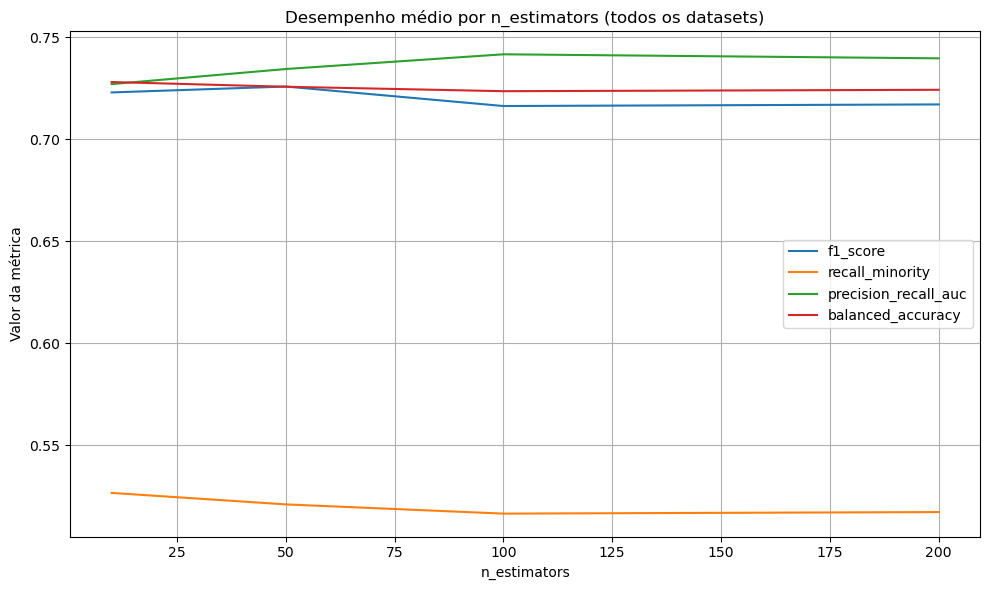

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Carregar os resultados
results_df = pd.read_csv(r'C:\Users\Utilizador\Desktop\RandomForest_v2\analise_inicial_est_rf.csv')

# Métricas que serão plotadas
metrics = ["f1_score", "recall_minority", "precision_recall_auc", "balanced_accuracy"]

# Agrupar pela média dos valores de n_estimators
mean_results = results_df.groupby("n_estimators")[metrics].mean().reset_index()

# Plotar todas as métricas em um único gráfico
plt.figure(figsize=(10, 6))
for metric in metrics:
    sns.lineplot(data=mean_results, x="n_estimators", y=metric, label=metric)

plt.title("Desempenho médio por n_estimators (todos os datasets)")
plt.xlabel("n_estimators")
plt.ylabel("Valor da métrica")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

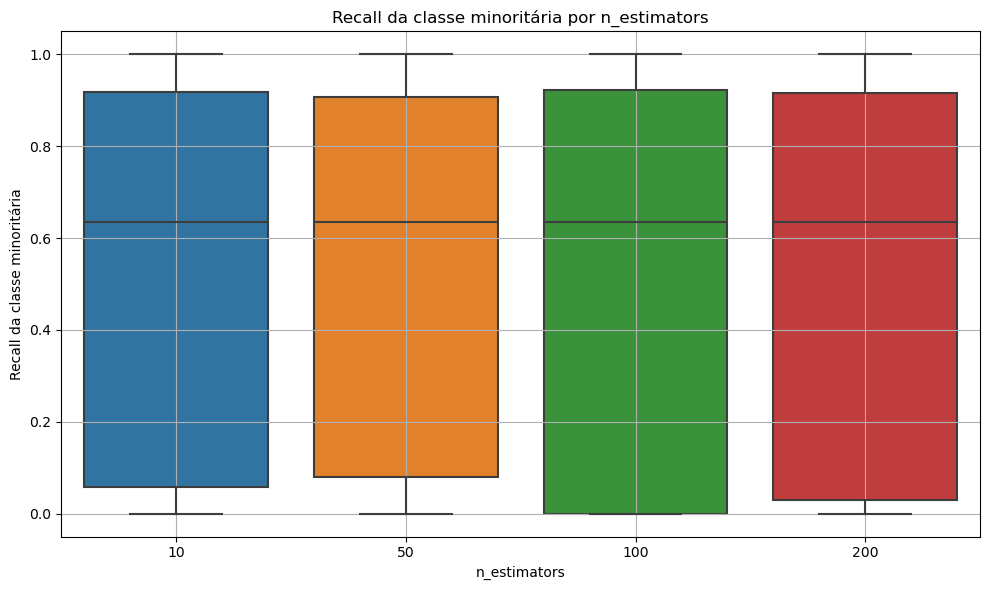

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lê os resultados
results_df = pd.read_csv(r'C:\Users\Utilizador\Desktop\RandomForest_v2\analise_inicial_est_rf.csv')

# Criar boxplot sem distinguir por tamanho
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x="n_estimators", y="recall_minority")
plt.title("Recall da classe minoritária por n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Recall da classe minoritária")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

df = pd.read_csv(r'C:\Users\Utilizador\Desktop\RandomForest_v2\analise_inicial_est_rf.csv')
df_100 = df[df["n_estimators"] == 100]
df_100 = df_100.drop("n_estimators",axis=1)
df_100.to_csv("analise_semmudanca.csv", index=False)

**Correr com a mudança**

1x

In [14]:
resultados_mudanca1x=[]
count = 1

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mla3.ensemble.random_forest import RandomForestClassifier  # Usando a tua implementação

for pasta in pastas:
    for arquivo in os.listdir(pasta):
        if arquivo.endswith(".csv"):
            
            caminho_arquivo = os.path.join(pasta, arquivo)
            print(f"\nTreino no dataset: {arquivo}")
            print(count, "de 48")
            count += 1

            # Carrega dados
            df = pd.read_csv(caminho_arquivo)
            X = df.iloc[:, :-1].values
            y = df.iloc[:, -1].values
            num_atributos = X.shape[1]
            # Divide treino/teste
            X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)
            
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=100,
                max_depth= 10,
                max_features= math.floor(math.sqrt(num_atributos)),
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)
            
            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)
                

            resultados_mudanca1x.append({
                "dataset": arquivo,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc
                })
            
resultados_mudanca_df1x = pd.DataFrame(resultados_mudanca1x)
resultados_mudanca_df1x.to_csv("analise_mudanca1x.csv", index=False)
print("\nResultados:")
print(resultados_mudanca_df1x)


Treino no dataset: dataset_1000_hypothyroid.csv
1 de 48

Treino no dataset: dataset_1002_ipums_la_98-small.csv
2 de 48

Treino no dataset: dataset_1014_analcatdata_dmft.csv
3 de 48

Treino no dataset: dataset_1016_vowel.csv
4 de 48

Treino no dataset: dataset_1018_ipums_la_99-small.csv
5 de 48

Treino no dataset: dataset_1020_mfeat-karhunen.csv
6 de 48

Treino no dataset: dataset_1021_page-blocks.csv
7 de 48

Treino no dataset: dataset_1022_mfeat-pixel.csv
8 de 48

Treino no dataset: dataset_1039_hiva_agnostic.csv
9 de 48

Treino no dataset: dataset_1049_pc4.csv
10 de 48

Treino no dataset: dataset_1050_pc3.csv
11 de 48

Treino no dataset: dataset_1056_mc1.csv
12 de 48

Treino no dataset: dataset_311_oil_spill.csv
13 de 48

Treino no dataset: dataset_38_sick.csv
14 de 48

Treino no dataset: dataset_958_segment.csv
15 de 48

Treino no dataset: dataset_962_mfeat-morphological.csv
16 de 48

Treino no dataset: dataset_966_analcatdata_halloffame.csv
17 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_971_mfeat-fourier.csv
18 de 48

Treino no dataset: dataset_976_JapaneseVowels.csv
19 de 48

Treino no dataset: dataset_978_mfeat-factors.csv
20 de 48

Treino no dataset: dataset_980_optdigits.csv
21 de 48

Treino no dataset: dataset_995_mfeat-zernike.csv
22 de 48

Treino no dataset: dataset_1004_synthetic_control.csv
23 de 48

Treino no dataset: dataset_1013_analcatdata_challenger.csv
24 de 48

Treino no dataset: dataset_1023_soybean.csv
25 de 48

Treino no dataset: dataset_1045_kc1-top5.csv
26 de 48

Treino no dataset: dataset_1059_ar1.csv
27 de 48

Treino no dataset: dataset_1061_ar4.csv
28 de 48

Treino no dataset: dataset_1064_ar6.csv
29 de 48

Treino no dataset: dataset_1065_kc3.csv
30 de 48

Treino no dataset: dataset_450_analcatdata_lawsuit.csv
31 de 48

Treino no dataset: dataset_463_backache.csv
32 de 48

Treino no dataset: dataset_757_meta.csv
33 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_764_analcatdata_apnea3.csv
34 de 48

Treino no dataset: dataset_765_analcatdata_apnea2.csv
35 de 48

Treino no dataset: dataset_767_analcatdata_apnea1.csv
36 de 48

Treino no dataset: dataset_865_analcatdata_neavote.csv
37 de 48

Treino no dataset: dataset_867_visualizing_livestock.csv
38 de 48

Treino no dataset: dataset_875_analcatdata_chlamydia.csv
39 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_940_water-treatment.csv
40 de 48

Treino no dataset: dataset_947_arsenic-male-bladder.csv
41 de 48

Treino no dataset: dataset_949_arsenic-female-bladder.csv
42 de 48

Treino no dataset: dataset_950_arsenic-female-lung.csv
43 de 48

Treino no dataset: dataset_951_arsenic-male-lung.csv
44 de 48

Treino no dataset: dataset_954_spectrometer.csv
45 de 48

Treino no dataset: dataset_968_analcatdata_birthday.csv
46 de 48

Treino no dataset: dataset_984_analcatdata_draft.csv
47 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_987_collins.csv
48 de 48

Resultados:
                                    dataset  f1_score  recall_minority  \
0              dataset_1000_hypothyroid.csv  0.481431         0.000000   
1        dataset_1002_ipums_la_98-small.csv  0.471516         0.000000   
2         dataset_1014_analcatdata_dmft.csv  0.437647         0.000000   
3                    dataset_1016_vowel.csv  0.471530         0.000000   
4        dataset_1018_ipums_la_99-small.csv  0.483852         0.000000   
5           dataset_1020_mfeat-karhunen.csv  0.477352         0.000000   
6              dataset_1021_page-blocks.csv  0.781128         0.331429   
7              dataset_1022_mfeat-pixel.csv  0.477352         0.000000   
8            dataset_1039_hiva_agnostic.csv  0.489738         0.000000   
9                      dataset_1049_pc4.csv  0.463804         0.000000   
10                     dataset_1050_pc3.csv  0.472379         0.000000   
11                     dataset_1056_mc1.csv  0

Taxa x2

In [57]:
resultados_mudanca=[]
count = 1

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mla2.ensemble.random_forest import RandomForestClassifier  # Usando a tua implementação

for pasta in pastas:
    for arquivo in os.listdir(pasta):
        if arquivo.endswith(".csv"):
            
            caminho_arquivo = os.path.join(pasta, arquivo)
            print(f"\nTreino no dataset: {arquivo}")
            print(count, "de 48")
            count += 1

            # Carrega dados
            df = pd.read_csv(caminho_arquivo)
            X = df.iloc[:, :-1].values
            y = df.iloc[:, -1].values
            num_atributos = X.shape[1]
            # Divide treino/teste
            X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)
            
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=100,
                max_depth= 10,
                max_features= math.floor(math.sqrt(num_atributos)),
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)
            
            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)
                

            resultados_mudanca.append({
                "dataset": arquivo,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc
                })
            
resultados_mudanca_df = pd.DataFrame(resultados_mudanca)
resultados_mudanca_df.to_csv("analise_mudanca2x.csv", index=False)
print("\nResultados:")
print(resultados_mudanca_df)


Treino no dataset: dataset_1000_hypothyroid.csv
1 de 48

Treino no dataset: dataset_1002_ipums_la_98-small.csv
2 de 48

Treino no dataset: dataset_1014_analcatdata_dmft.csv
3 de 48

Treino no dataset: dataset_1016_vowel.csv
4 de 48

Treino no dataset: dataset_1018_ipums_la_99-small.csv
5 de 48

Treino no dataset: dataset_1020_mfeat-karhunen.csv
6 de 48

Treino no dataset: dataset_1021_page-blocks.csv
7 de 48

Treino no dataset: dataset_1022_mfeat-pixel.csv
8 de 48

Treino no dataset: dataset_1039_hiva_agnostic.csv
9 de 48

Treino no dataset: dataset_1049_pc4.csv
10 de 48

Treino no dataset: dataset_1050_pc3.csv
11 de 48

Treino no dataset: dataset_1056_mc1.csv
12 de 48

Treino no dataset: dataset_311_oil_spill.csv
13 de 48

Treino no dataset: dataset_38_sick.csv
14 de 48

Treino no dataset: dataset_958_segment.csv
15 de 48

Treino no dataset: dataset_962_mfeat-morphological.csv
16 de 48

Treino no dataset: dataset_966_analcatdata_halloffame.csv
17 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_971_mfeat-fourier.csv
18 de 48

Treino no dataset: dataset_976_JapaneseVowels.csv
19 de 48

Treino no dataset: dataset_978_mfeat-factors.csv
20 de 48

Treino no dataset: dataset_980_optdigits.csv
21 de 48

Treino no dataset: dataset_995_mfeat-zernike.csv
22 de 48

Treino no dataset: dataset_1004_synthetic_control.csv
23 de 48

Treino no dataset: dataset_1013_analcatdata_challenger.csv
24 de 48

Treino no dataset: dataset_1023_soybean.csv
25 de 48

Treino no dataset: dataset_1045_kc1-top5.csv
26 de 48

Treino no dataset: dataset_1059_ar1.csv
27 de 48

Treino no dataset: dataset_1061_ar4.csv
28 de 48

Treino no dataset: dataset_1064_ar6.csv
29 de 48

Treino no dataset: dataset_1065_kc3.csv
30 de 48

Treino no dataset: dataset_450_analcatdata_lawsuit.csv
31 de 48

Treino no dataset: dataset_463_backache.csv
32 de 48

Treino no dataset: dataset_757_meta.csv
33 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_764_analcatdata_apnea3.csv
34 de 48

Treino no dataset: dataset_765_analcatdata_apnea2.csv
35 de 48

Treino no dataset: dataset_767_analcatdata_apnea1.csv
36 de 48

Treino no dataset: dataset_865_analcatdata_neavote.csv
37 de 48

Treino no dataset: dataset_867_visualizing_livestock.csv
38 de 48

Treino no dataset: dataset_875_analcatdata_chlamydia.csv
39 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:41: RuntimeWarning: invalid value encountered in less
  left_mask = X < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:42: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:35: RuntimeWarning: invalid value encountered in less
  left_mask = X[:, column] < value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\base.py:36: RuntimeWarning: invalid value encountered in greater_equal
  right_mask = X[:, column] >= value
c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_940_water-treatment.csv
40 de 48

Treino no dataset: dataset_947_arsenic-male-bladder.csv
41 de 48

Treino no dataset: dataset_949_arsenic-female-bladder.csv
42 de 48

Treino no dataset: dataset_950_arsenic-female-lung.csv
43 de 48

Treino no dataset: dataset_951_arsenic-male-lung.csv
44 de 48

Treino no dataset: dataset_954_spectrometer.csv
45 de 48

Treino no dataset: dataset_968_analcatdata_birthday.csv
46 de 48

Treino no dataset: dataset_984_analcatdata_draft.csv
47 de 48


c:\Users\Utilizador\Desktop\RandomForest_v2\mla2\ensemble\tree.py:195: RuntimeWarning: invalid value encountered in divide
  leaf_distribution = leaf_counts / targets["y"].shape[0]



Treino no dataset: dataset_987_collins.csv
48 de 48

Resultados:
                                    dataset  f1_score  recall_minority  \
0              dataset_1000_hypothyroid.csv  0.481431         0.000000   
1        dataset_1002_ipums_la_98-small.csv  0.471516         0.000000   
2         dataset_1014_analcatdata_dmft.csv  0.437647         0.000000   
3                    dataset_1016_vowel.csv  0.471530         0.000000   
4        dataset_1018_ipums_la_99-small.csv  0.483852         0.000000   
5           dataset_1020_mfeat-karhunen.csv  0.477352         0.000000   
6              dataset_1021_page-blocks.csv  0.800981         0.377143   
7              dataset_1022_mfeat-pixel.csv  0.477352         0.000000   
8            dataset_1039_hiva_agnostic.csv  0.489738         0.000000   
9                      dataset_1049_pc4.csv  0.463804         0.000000   
10                     dataset_1050_pc3.csv  0.472379         0.000000   
11                     dataset_1056_mc1.csv  0

In [ ]:
resultados_mudanca_df3x=[]
count = 1

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mla4.ensemble.random_forest import RandomForestClassifier  # Usando a tua implementação

for pasta in pastas:
    for arquivo in os.listdir(pasta):
        if arquivo.endswith(".csv"):
            
            caminho_arquivo = os.path.join(pasta, arquivo)
            print(f"\nTreino no dataset: {arquivo}")
            print(count, "de 48")
            count += 1

            # Carrega dados
            df = pd.read_csv(caminho_arquivo)
            X = df.iloc[:, :-1].values
            y = df.iloc[:, -1].values
            num_atributos = X.shape[1]
            # Divide treino/teste
            X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, random_state=42)
            
            # Treina modelo
            modelo = RandomForestClassifier(
                n_estimators=100,
                max_depth= 10,
                max_features= math.floor(math.sqrt(num_atributos)),
            )
            modelo.fit(X_train, y_train)

            # Previsão
            y_pred_prob = modelo._predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)
            
            # Métricas
            f1 = f1_score(y_test, y_pred)
            rec_min = recall_minority(y_test, y_pred)
            pr_auc = precision_recall_auc(y_test, y_pred_prob)
            bal_acc = balanced_accuracy(y_test, y_pred)
                

            resultados_mudanca_df.append({
                "dataset": arquivo,
                "f1_score": f1,
                "recall_minority": rec_min,
                "precision_recall_auc": pr_auc,
                "balanced_accuracy": bal_acc
                })
            
resultados_mudanca_df = pd.DataFrame(resultados_mudanca)
resultados_mudanca_df.to_csv("analise_mudanca3x.csv", index=False)
print("\nResultados:")
print(resultados_mudanca_df)

Comparação 1x e 2x

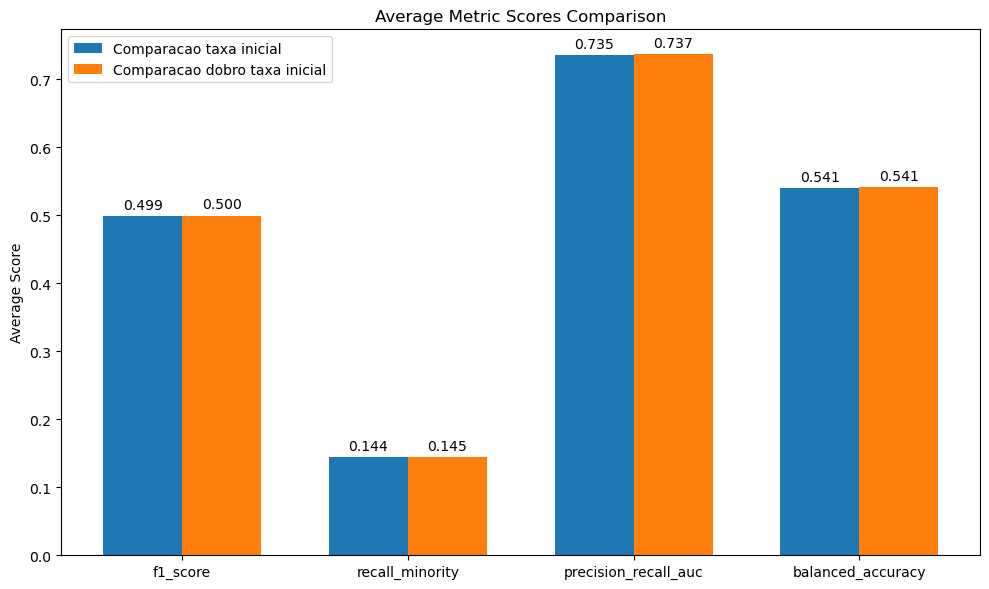

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSVs
df1 = pd.read_csv('analise_mudanca1x.csv')
df2 = pd.read_csv('analise_mudanca2x.csv')

metrics = ['f1_score', 'recall_minority', 'precision_recall_auc', 'balanced_accuracy']

# Calculate average of each metric in both files
avg1 = df1[metrics].mean()
avg2 = df2[metrics].mean()

# Prepare data for plotting
plot_df = pd.DataFrame({
    'Metric': metrics,
    'File 1': avg1.values,
    'File 2': avg2.values
})

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, plot_df['File 1'], width, label='Comparacao taxa inicial')
bars2 = ax.bar(x + width/2, plot_df['File 2'], width, label='Comparacao dobro taxa inicial')

ax.set_ylabel('Average Score')
ax.set_title('Average Metric Scores Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


# Comparação de resultados

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon, shapiro


df_depois = pd.read_csv("analise_mudanca.csv")
df_antes = pd.read_csv("analise_semmudanca.csv")

df_depois = df_depois.sort_values(by="dataset").reset_index(drop=True)
df_antes = df_antes.sort_values(by="dataset").reset_index(drop=True)

assert (df_depois['dataset'] == df_antes['dataset']).all(), "Os datasets não estão alinhados!"

metricas = ['f1_score', 'recall_minority', 'precision_recall_auc', 'balanced_accuracy']
resultados = []

for metrica in metricas:
    antes = df_antes[metrica]
    depois = df_depois[metrica]
    diferencas = depois - antes

    #Teste de normalidade (Shapiro-Wilk)
    stat_normalidade, p_normalidade = shapiro(diferencas)
    normal = p_normalidade > 0.05

    #Aplicação do teste apropriado
    if normal:
        stat_test, p_valor = ttest_rel(depois, antes, alternative='greater')
        teste_usado = 't-teste pareado'
    else:
        stat_test, p_valor = wilcoxon(depois, antes, alternative='greater')
        teste_usado = 'Wilcoxon'

    resultados.append({
        "métrica": metrica,
        "média_antes": antes.mean(),
        "média_depois": depois.mean(),
        "diferença média": diferencas.mean(),
        "normalidade (p)": round(p_normalidade, 4),
        "teste": teste_usado,
        "p-valor": round(p_valor, 4)
    })

#Correção de Bonferroni
alpha = 0.05
alpha_corrigido = alpha / len(metricas)

df_resultados = pd.DataFrame(resultados)
df_resultados["significativo"] = df_resultados["p-valor"] < alpha_corrigido

df_resultados.to_csv("resultados_estatisticos.csv", index=False)

c:\Users\Utilizador\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


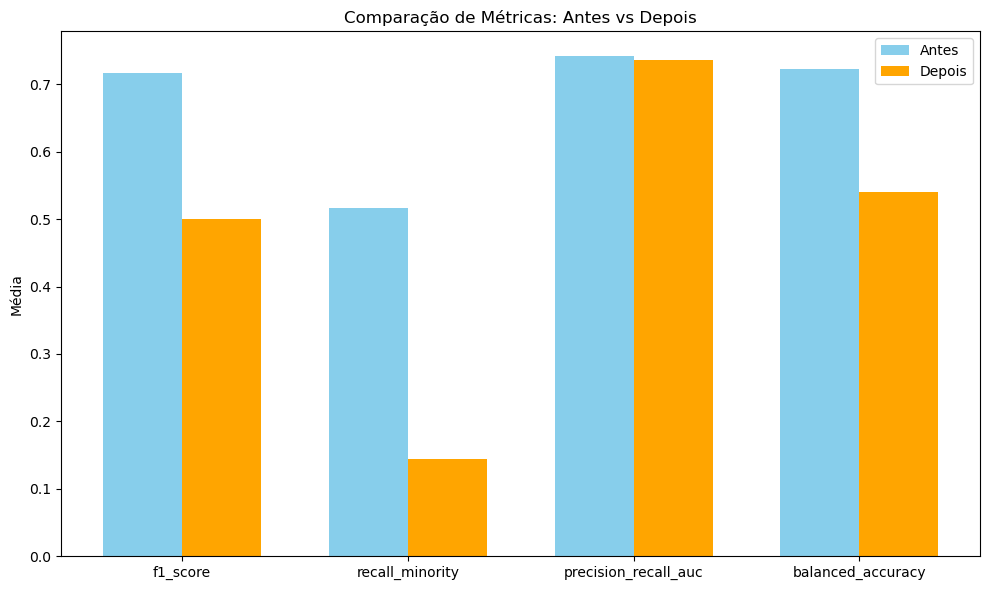

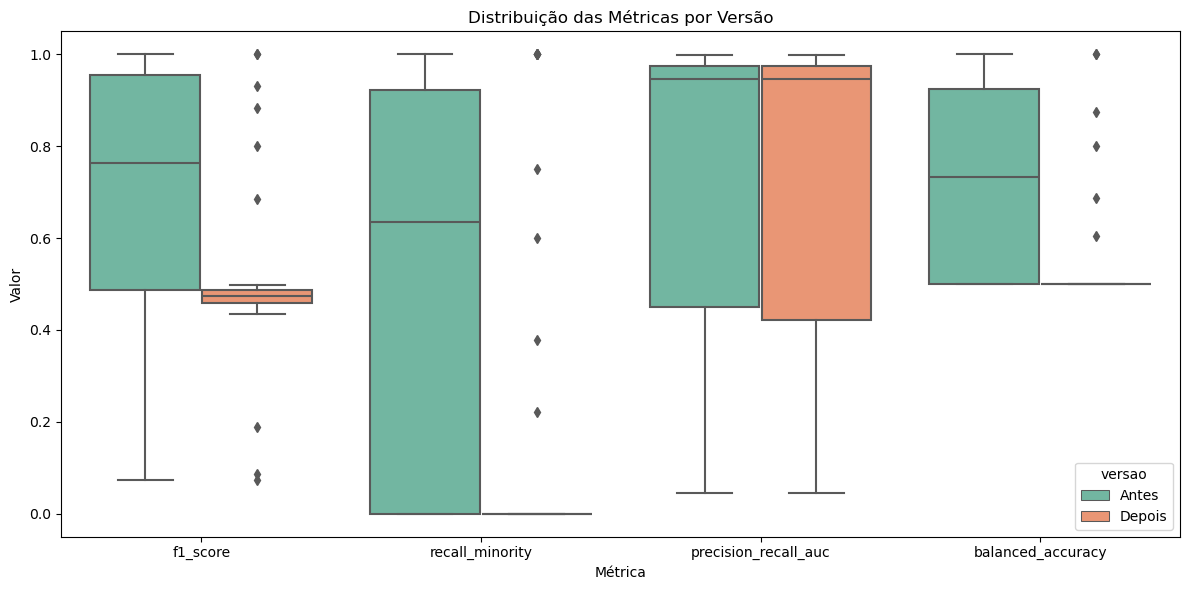

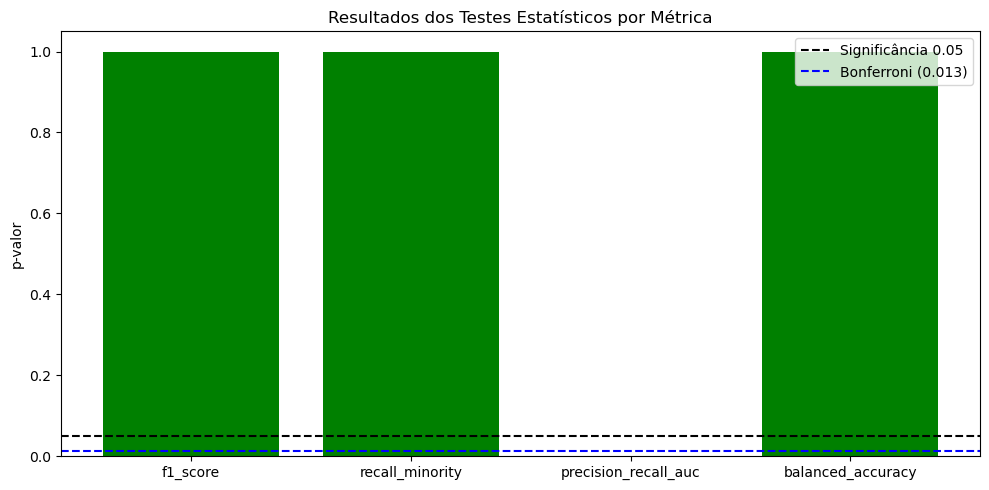

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df_dif = df_depois.copy()
metricas = ['f1_score', 'recall_minority', 'precision_recall_auc', 'balanced_accuracy']
for col in metricas:
    df_dif[col + "_diff"] = df_depois[col] - df_antes[col]


plt.figure(figsize=(10, 6))
largura = 0.35
x = np.arange(len(metricas))
val_antes = [df_antes[m].mean() for m in metricas]
val_depois = [df_depois[m].mean() for m in metricas]

plt.bar(x - largura/2, val_antes, width=largura, label="Antes", color='skyblue')
plt.bar(x + largura/2, val_depois, width=largura, label="Depois", color='orange')

plt.xticks(x, metricas)
plt.ylabel("Média")
plt.title("Comparação de Métricas: Antes vs Depois")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
df_plot = pd.concat([
    df_antes[metricas].assign(versao='Antes'),
    df_depois[metricas].assign(versao='Depois')
])
df_melt = df_plot.melt(id_vars='versao', var_name='Métrica', value_name='Valor')

sns.boxplot(x='Métrica', y='Valor', hue='versao', data=df_melt, palette='Set2')
plt.title("Distribuição das Métricas por Versão")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
cores = ['green' if row['teste'] == 'Wilcoxon' else 'red' for _, row in df_resultados.iterrows()]
plt.bar(df_resultados['métrica'], df_resultados['p-valor'], color=cores)

plt.axhline(0.05, color='black', linestyle='--', label='Significância 0.05')
plt.axhline(0.05 / len(metricas), color='blue', linestyle='--', label=f'Bonferroni ({0.05 / len(metricas):.3f})')
plt.ylabel("p-valor")
plt.title("Resultados dos Testes Estatísticos por Métrica")
plt.legend()
plt.tight_layout()
plt.show()